In [1]:
from random import randrange


def generate_list(size: int) -> list[int]:
    '''Generates a list of random numbers of length `size`, on numbers on `range(size)`'''
    return [randrange(size) for i in range(size)]


In [2]:
from threading import Thread


def merge(a: list[int], b: list[int]) -> list[int]:
    '''Merges two lists `a` and `b` into a single sorted list'''
    i = j = 0
    result = []
    while i < len(a) and j < len(b):
        if a[i] < b[j]:
            result.append(a[i])
            i += 1
        else:
            result.append(b[j])
            j += 1
    result += a[i:]
    result += b[j:]
    return result


def sort(list: list[int], thread_id: int):
    list.sort()
    print(f"Thread {thread_id}:\tSorted {len(list)} elements")


def mergesort_threaded(list: list[int], threads: int):
    '''Sorts a list using in-place non-recursive mergesort, where it splits the job size into `threads` slices and sorts each slice in a single thread, then joing them back'''
    if len(list) <= threads:
        print("List is too small to split into threads")
        return list

    # Split the list into `threads` slices
    # Only the last element can be 1 smaller
    slices = []
    slice_size = len(list) // threads
    for i in range(threads):
        if i == threads - 1:
            slices.append(list[i * slice_size:])
        else:
            slices.append(list[i * slice_size:(i + 1) * slice_size])

    # Sort each slice in a thread
    threads = [Thread(target=sort, args=(slice, i))
               for (i, slice) in enumerate(slices)]
    for thread in threads:
        thread.start()

    # Sync point: join the threads back
    for thread in threads:
        thread.join()

    # Merge pairs of the now sorted slices using threads:
    while len(slices) > 1:
        threads = []
        for i in range(0, len(slices), 2):
            if i + 1 < len(slices):
                threads.append(
                    Thread(target=merge, args=(slices[i], slices[i + 1])))
            else:
                threads.append(Thread(target=merge, args=(slices[i], [])))

        for thread in threads:
            thread.start()
        for thread in threads:
            thread.join()

        slices = [slices[i] for i in range(0, len(slices), 2)]


In [3]:
from typing import Callable
from time import time


def run(list_size: int, rounds: int, parallels: int, func: Callable[list[int], int]) -> list[float]:
    '''gens 1 new list per round, to decrease variability'''

    times = []
    print(
        f"Running {func.__name__} for list size {list_size} and {rounds} rounds")

    for round in range(rounds):
        list = generate_list(list_size)

        # record time elapsed
        start = time()
        func(list, parallels)
        elapsed = time() - start
        print(f"Round {round + 1} finished with time {elapsed}")
        times.append(elapsed)

    return times


In [4]:
threaded_500k_1t = run(list_size=500000, rounds=20,
                       parallels=1, func=mergesort_threaded)
threaded_500k_2t = run(list_size=500000, rounds=20,
                       parallels=2, func=mergesort_threaded)
threaded_500k_4t = run(list_size=500000, rounds=20,
                       parallels=4, func=mergesort_threaded)
threaded_500k_8t = run(list_size=500000, rounds=20,
                       parallels=8, func=mergesort_threaded)
# proccess = run(list_size=10000, rounds=10, parallels=5, func=mergesort_proccess)


Running mergesort_threaded for list size 500000 and 20 rounds
Thread 0:	Sorted 500000 elements
Round 1 finished with time 0.16324186325073242
Thread 0:	Sorted 500000 elements
Round 2 finished with time 0.16204619407653809
Thread 0:	Sorted 500000 elements
Round 3 finished with time 0.18979597091674805
Thread 0:	Sorted 500000 elements
Round 4 finished with time 0.1741929054260254
Thread 0:	Sorted 500000 elements
Round 5 finished with time 0.18550896644592285
Thread 0:	Sorted 500000 elements
Round 6 finished with time 0.2582399845123291
Thread 0:	Sorted 500000 elements
Round 7 finished with time 0.18748903274536133
Thread 0:	Sorted 500000 elements
Round 8 finished with time 0.1862630844116211
Thread 0:	Sorted 500000 elements
Round 9 finished with time 0.16786885261535645
Thread 0:	Sorted 500000 elements
Round 10 finished with time 0.15154218673706055
Thread 0:	Sorted 500000 elements
Round 11 finished with time 0.1613469123840332
Thread 0:	Sorted 500000 elements
Round 12 finished with time

In [5]:
import pandas as pd

# import the results each to its own dataframe for better processing
df_1t = pd.DataFrame(threaded_500k_1t, columns=["1 thread"])
df_2t = pd.DataFrame(threaded_500k_2t, columns=["2 threads"])
df_4t = pd.DataFrame(threaded_500k_4t, columns=["4 threads"])
df_8t = pd.DataFrame(threaded_500k_8t, columns=["8 threads"])

df = pd.concat([df_1t, df_2t, df_4t, df_8t], axis=1)


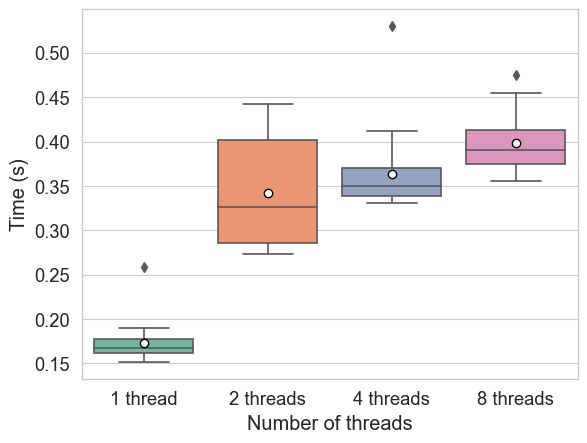

In [6]:
import seaborn as sns
import matplotlib as plt


def plot(data: pd.DataFrame):
    '''Plots a list of lists of times, each list is a different algorithm'''
    # dict keys are labels and values are lists of times
    sns.set_theme()
    sns.set_style("whitegrid")
    sns.set_context("paper", font_scale=1.5)
    sns.set_palette("Set2")
    sns.boxplot(data=data, showmeans=True, meanprops={
                "marker": "o", "markerfacecolor": "white", "markeredgecolor": "black"})
    plt.pyplot.xlabel("Number of threads")
    plt.pyplot.ylabel("Time (s)")
    plt.pyplot.show()


plot(df)
